In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Group attribute indices based on categories
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54,58)),
    "has_back_color":list(range(58,73)),
    "has_tail_shape": list(range(73,79)),
    "has_upper_tail_color":list(range(79,94)),
    "has_head_pattern":list(range(94,105)),
    "has_breast_color":list(range(105,120)),
    "has_throat_color":list(range(120,135)),
    "has_eye_color":list(range(135,149)),
    "has_bill_length":list(range(149,152)),
    "has_forehead_color":list(range(152,167)),
    "has_under_tail_color":list(range(167,182)),
    "has_nape_color":list(range(182,197)),
    "has_belly_color":list(range(197,212)),
    "has_wing_shape":list(range(212,217)),
    "has_size":list(range(217,222)),
    "has_shape":list(range(222,236)),
    "has_back_pattern":list(range(236,240)),
    "has_tail_pattern":list(range(240,244)),
    "has_belly_pattern":list(range(244,248)),
    "has_primary_color":list(range(248,263)),
    "has_leg_color":list(range(263,278)),
    "has_bill_color":list(range(278,293)),
    "has_crown_color":list(range(293,308)),
    "has_wing_pattern":list(range(308,312))
}

# Define a new model architecture
class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Save the in_features of the original fully connected layer
        in_features = self.resnet.fc.in_features
        
        # Replace the final fully connected layer with Identity
        self.resnet.fc = nn.Identity()
        
        # Create a separate classifier for each attribute group
        self.group_classifiers = nn.ModuleDict({
            group_name: nn.Sequential(
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, len(indices)),
                nn.Softmax(dim=1)
            )
            for group_name, indices in attribute_groups.items()
        })
    
    def forward(self, x):
        features = self.resnet(x)  # Extract features using ResNet backbone
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.group_classifiers.items()
        }
        return outputs

# Update dataset to return labels grouped by attribute categories
class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, image_size=(224, 224)):
        self.image_paths = self.get_image_paths(image_dir)
        self.labels = self.load_labels(label_file, attribute_groups)
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def get_image_paths(self, image_dir):
        image_paths = glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True)
        return sorted(image_paths)
    
    def load_labels(self, label_file, attribute_groups):
        with open(label_file, 'r') as file:
            labels = [list(map(int, line.strip().split())) for line in file]
        grouped_labels = [
            {group_name: np.argmax([line[idx] for idx in indices]) for group_name, indices in attribute_groups.items()}
            for line in labels
        ]
        return grouped_labels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Training and evaluation updates
def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            # Labels is a dictionary where each key is a group name
            labels = {group: label.to(device) for group, label in labels.items()}
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute loss for each group and aggregate
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


def evaluate_grouped_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            # Compute loss and accuracy for each group
            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()
                
                # Get predictions and compute accuracy
                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)
    
    # Print metrics for each group
    for group in attribute_groups.keys():
        accuracy = correct_predictions[group] / total_samples[group]
        print(f"Group: {group}, Accuracy: {accuracy:.4f}")
    
    print(f"Total Loss: {total_loss / len(test_loader):.4f}")



In [11]:
# Paths to data
train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"

# Hyperparameters
n_labels = 312
batch_size = 32
epochs = 1
learning_rate = 0.001
# Prepare datasets and dataloaders
image_size = (224, 224)  # Required input size for ResNet
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, image_size)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, image_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNetGroupedMultiClass(attribute_groups).to(device)
criterion = {group: nn.CrossEntropyLoss() for group in attribute_groups.keys()}
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
train_grouped_model(model, train_loader, criterion, optimizer, epochs=1)


Epoch 1/1, Loss: 57.9816


In [13]:
evaluate_grouped_model(model, test_loader, criterion)


Group: has_bill_shape, Accuracy: 0.4032
Group: has_wing_color, Accuracy: 0.2756
Group: has_upperparts_color, Accuracy: 0.2525
Group: has_underparts_color, Accuracy: 0.2128
Group: has_breast_pattern, Accuracy: 0.6357
Group: has_back_color, Accuracy: 0.2620
Group: has_tail_shape, Accuracy: 0.3143
Group: has_upper_tail_color, Accuracy: 0.3716
Group: has_head_pattern, Accuracy: 0.2508
Group: has_breast_color, Accuracy: 0.2069
Group: has_throat_color, Accuracy: 0.2482
Group: has_eye_color, Accuracy: 0.8110
Group: has_bill_length, Accuracy: 0.5875
Group: has_forehead_color, Accuracy: 0.2477
Group: has_under_tail_color, Accuracy: 0.2855
Group: has_nape_color, Accuracy: 0.2168
Group: has_belly_color, Accuracy: 0.2389
Group: has_wing_shape, Accuracy: 0.6243
Group: has_size, Accuracy: 0.5287
Group: has_shape, Accuracy: 0.4879
Group: has_back_pattern, Accuracy: 0.5849
Group: has_tail_pattern, Accuracy: 0.5982
Group: has_belly_pattern, Accuracy: 0.6921
Group: has_primary_color, Accuracy: 0.2572
Gr

In [14]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, attribute_groups, n_samples=5):
    model.eval()
    samples_shown = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if samples_shown >= n_samples:
                    return
                
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
                img = np.clip(img, 0, 1)
                
                true_labels = {
                    group: torch.argmax(labels[group][i]).item() for group in attribute_groups.keys()
                }
                predicted_labels = {
                    group: torch.argmax(outputs[group][i]).item() for group in attribute_groups.keys()
                }
                
                # Display the image
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title("Predictions vs Actuals")
                
                # Display true and predicted labels
                true_label_text = "\n".join([f"{group}: {label}" for group, label in true_labels.items()])
                pred_label_text = "\n".join([f"{group}: {label}" for group, label in predicted_labels.items()])
                
                plt.text(1.1, 0.5, f"True Labels:\n{true_label_text}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')
                plt.text(1.5, 0.5, f"Predicted Labels:\n{pred_label_text}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')
                
                plt.show()
                samples_shown += 1


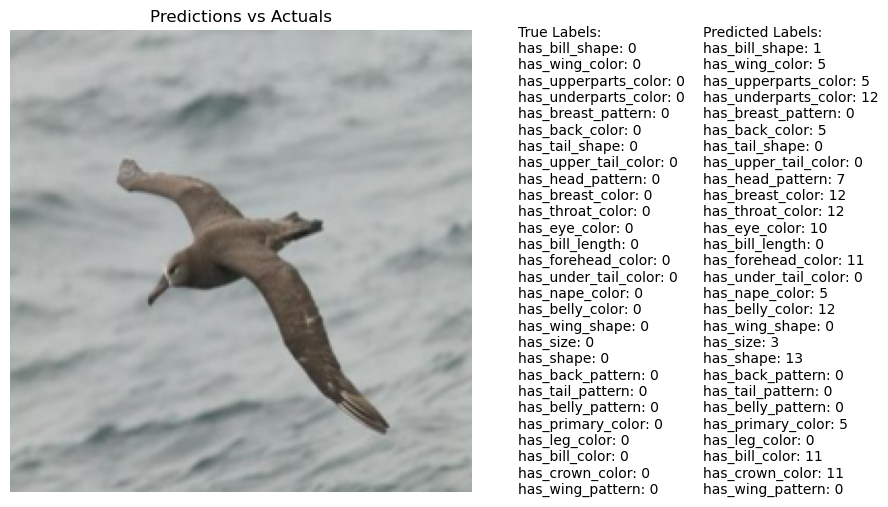

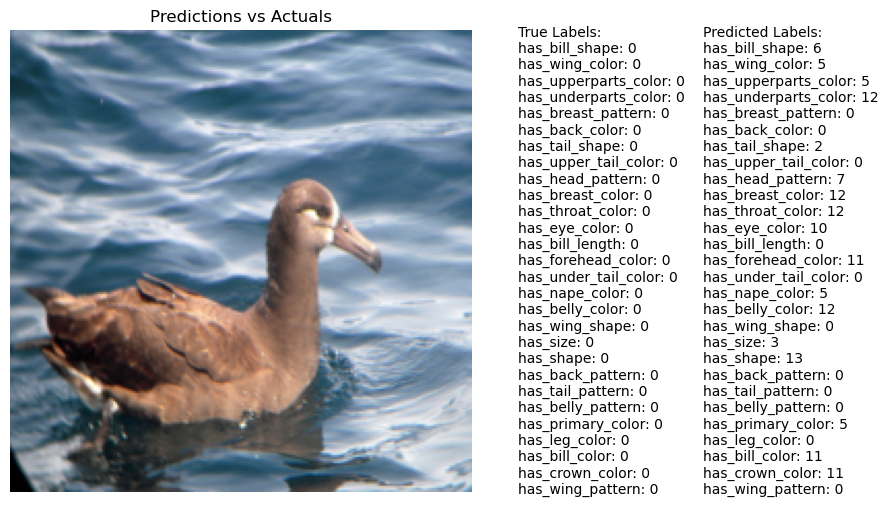

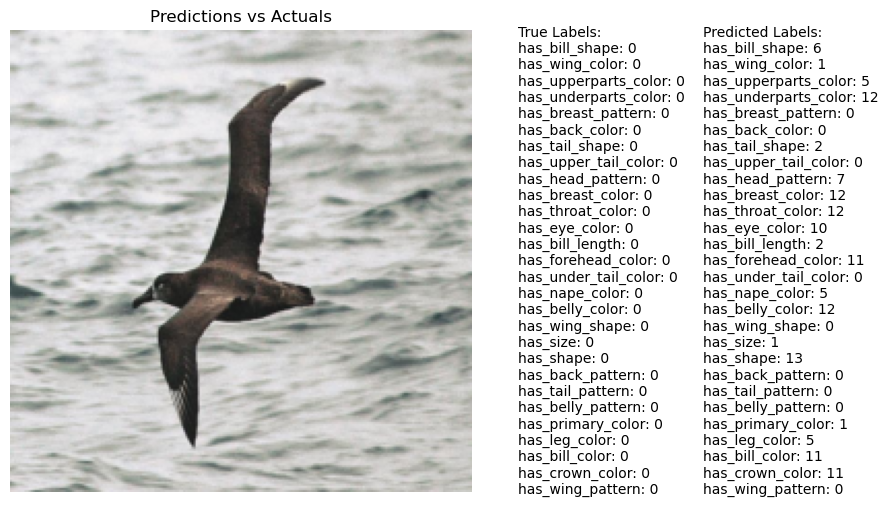

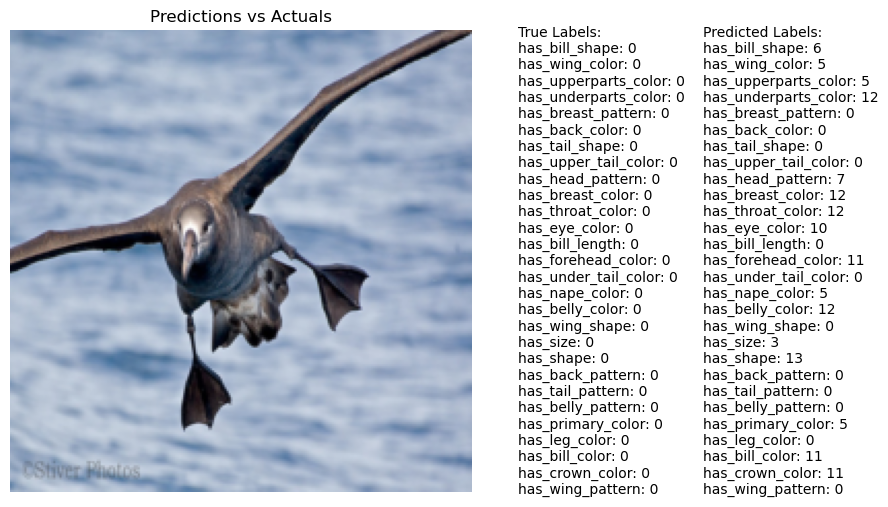

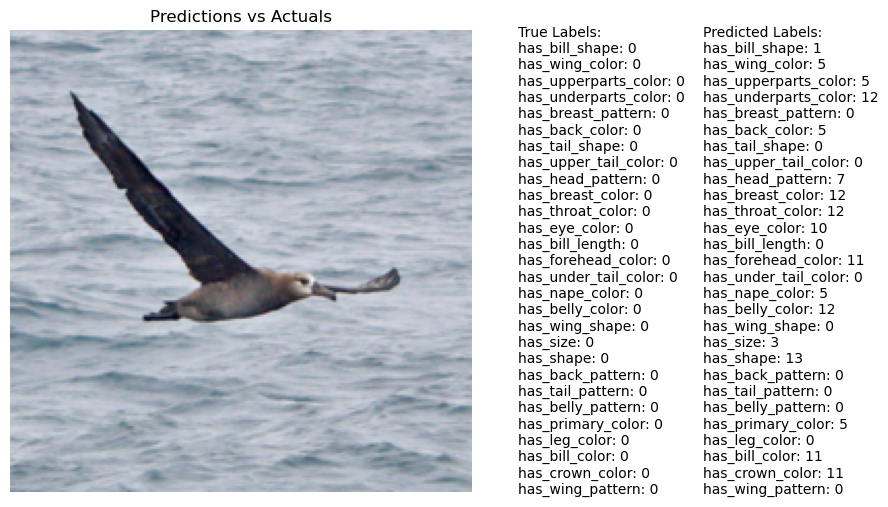

In [15]:
visualize_predictions(model, test_loader, attribute_groups, n_samples=5)
